#**Biomarker  Discovery Assignment**



#### Task:

Using the Golub et. al. as a reference:
* Recreate Figure 3b - See how many overlaps you have with their top correlated genes.
* Train a model using the 50 most highly correlated genes (25 AML and 25 ALL) to predict the class of each sample using cross-validation.
* Try differing amounts of genes and compare the results eg:(top 2, 10, 100, 1000)
* Cluster the data using any method you like (K-Means, Hierarchical). What are the defining features of the clusters?
* *Optional:* Does sample type matter (bone marrow vs peripheral blood)?


In [178]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive/')

# generate plots in the jupyter notebook
%matplotlib inline


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [179]:
os.chdir('/content/gdrive/MyDrive/Colab_projects/Bioinformatics_class/biomarker_discovery')

In [180]:
df = pd.read_csv("data_set_ALL_AML_train.tsv", sep='\t', header= 0, index_col=False)
print(df.shape) 
df

(7129, 78)


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,call.4,6,call.5,7,call.6,8,call.7,9,call.8,10,call.9,11,call.10,12,call.11,13,call.12,14,call.13,15,call.14,16,call.15,17,call.16,18,call.17,19,call.18,20,call.19,21,call.20,22,call.21,23,call.22,24,call.23,25,call.24,26,call.25,27,call.26,34,call.27,35,call.28,36,call.29,37,call.30,38,call.31,28,call.32,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,A,-138,A,-72,A,-413,A,5,A,-88,A,-165,A,-67,A,-92,A,-113,A,-107,A,-117,A,-476,A,-81,A,-44,A,17,A,-144,A,-247,A,-74,A,-120,A,-81,A,-112,A,-273,A,-20,A,7,A,-213,A,-25,A,-72,A,-4,A,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,A,-85,A,-144,A,-260,A,-127,A,-105,A,-155,A,-93,A,-119,A,-147,A,-72,A,-219,A,-213,A,-150,A,-51,A,-229,A,-199,A,-90,A,-321,A,-263,A,-150,A,-233,A,-327,A,-207,A,-100,A,-252,A,-20,A,-139,A,-116,A,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,A,215,A,238,A,7,A,106,A,42,A,-71,A,84,A,-31,A,-118,A,-126,A,-50,A,-18,A,-119,A,100,A,79,A,-157,A,-168,A,-11,A,-114,A,-85,A,-78,A,-76,A,-50,A,-57,A,136,A,124,A,-1,A,-125,A,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,A,71,A,55,A,-2,A,268,A,219,M,82,A,25,A,173,A,243,M,149,A,257,A,301,A,78,A,207,A,218,A,132,A,-24,A,-36,A,255,A,316,A,54,A,81,A,101,A,132,A,318,A,325,A,392,P,241,A,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,A,-272,A,-399,A,-541,A,-210,A,-178,A,-163,A,-179,A,-233,A,-127,A,-205,A,-218,A,-403,A,-152,A,-146,A,-262,A,-151,A,-308,A,-317,A,-342,A,-418,A,-244,A,-439,A,-369,A,-377,A,-209,A,-396,A,-324,A,-191,A,-51,A,-139,A,-367,A,-188,A,-407,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,793,A,782,A,1138,A,627,A,250,A,645,A,1140,A,1799,A,758,A,570,A,672,A,291,A,696,A,431,A,195,A,736,A,1701,A,636,A,538,A,1435,A,208,A,1010,A,617,A,646,A,1034,A,838,A,583,A,834,A,752,A,1293,A,1733,A,1567,A,987,A,279,A,737,A,588,A,1170,A,2315,A
7125,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,329,A,295,A,777,P,170,A,314,A,341,A,482,A,446,P,385,A,359,P,208,A,41,A,302,A,269,A,59,A,445,P,1109,P,205,P,90,A,255,A,113,A,405,A,336,A,391,A,69,A,313,P,677,A,557,A,295,A,342,A,304,A,627,A,279,A,51,A,227,A,361,A,284,A,250,A
7126,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,36,A,11,A,41,A,-50,A,14,A,26,A,10,A,59,A,115,P,9,A,25,A,8,A,24,A,8,A,31,A,42,A,61,A,17,A,-50,A,53,A,-8,A,19,A,9,A,81,A,24,A,21,A,-1,A,-12,A,28,A,26,A,12,A,21,A,22,A,6,A,-9,A,-26,A,39,A,-12,A
7127,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,191,A,76,A,228,A,126,A,56,A,193,A,369,P,781,P,244,A,171,M,116,A,-2,A,74,A,163,A,116,A,246,P,526,A,127,A,333,A,545,P,22,A,270,M,243,M,203,A,807,P,145,A,208,A,335,M,1558,P,246,A,3193,P,2520,P,662,P,2484,P,371,A,133,A,298,A,790,P


In [181]:
# drop call QC columns
df = df.loc[:, ~df.columns.str.startswith('call')]
print(df.shape) # 40 columns; 38 samples, one description column, one gene accession number; 7,129 genes (rows)
df

(7129, 40)


,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,34,35,36,37,38,28,29,30,31,32,33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,5,-88,-165,-67,-92,-113,-107,-117,-476,-81,-44,17,-144,-247,-74,-120,-81,-112,-273,-20,7,-213,-25,-72,-4,15,-318,-32,-124,-135
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,-127,-105,-155,-93,-119,-147,-72,-219,-213,-150,-51,-229,-199,-90,-321,-263,-150,-233,-327,-207,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,106,42,-71,84,-31,-118,-126,-50,-18,-119,100,79,-157,-168,-11,-114,-85,-78,-76,-50,-57,136,124,-1,-125,2,-95,49,-37,-70
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,268,219,82,25,173,243,149,257,301,78,207,218,132,-24,-36,255,316,54,81,101,132,318,325,392,241,193,312,230,330,337
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,-210,-178,-163,-179,-233,-127,-205,-218,-403,-152,-146,-262,-151,-308,-317,-342,-418,-244,-439,-369,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,X83863_at,793,782,1138,627,250,645,1140,1799,758,570,672,291,696,431,195,736,1701,636,538,1435,208,1010,617,646,1034,838,583,834,752,1293,1733,1567,987,279,737,588,1170,2315
7125,HMG2 High-mobility group (nonhistone chromosom...,Z17240_at,329,295,777,170,314,341,482,446,385,359,208,41,302,269,59,445,1109,205,90,255,113,405,336,391,69,313,677,557,295,342,304,627,279,51,227,361,284,250
7126,RB1 Retinoblastoma 1 (including osteosarcoma),L49218_f_at,36,11,41,-50,14,26,10,59,115,9,25,8,24,8,31,42,61,17,-50,53,-8,19,9,81,24,21,-1,-12,28,26,12,21,22,6,-9,-26,39,-12
7127,GB DEF = Glycophorin Sta (type A) exons 3 and ...,M71243_f_at,191,76,228,126,56,193,369,781,244,171,116,-2,74,163,116,246,526,127,333,545,22,270,243,203,807,145,208,335,1558,246,3193,2520,662,2484,371,133,298,790


In [182]:
df[df["Gene Accession Number"].duplicated() == True].shape

(0, 40)

In [183]:
df[df["Gene Description"].duplicated() == True].shape # 502 duplicated gene descriptions; while no gene accession numbers are duplicated; must have transcripts which map to same gene name; we're going to pick top genes based on unique accession numbers

(502, 40)

In [184]:
genes_df = df[["Gene Accession Number", "Gene Description"]]
genes_df

,Gene Accession Number,Gene Description
0,AFFX-BioB-5_at,AFFX-BioB-5_at (endogenous control)
1,AFFX-BioB-M_at,AFFX-BioB-M_at (endogenous control)
2,AFFX-BioB-3_at,AFFX-BioB-3_at (endogenous control)
3,AFFX-BioC-5_at,AFFX-BioC-5_at (endogenous control)
4,AFFX-BioC-3_at,AFFX-BioC-3_at (endogenous control)
...,...,...
7124,X83863_at,PTGER3 Prostaglandin E receptor 3 (subtype EP3...
7125,Z17240_at,HMG2 High-mobility group (nonhistone chromosom...
7126,L49218_f_at,RB1 Retinoblastoma 1 (including osteosarcoma)
7127,M71243_f_at,GB DEF = Glycophorin Sta (type A) exons 3 and ...


In [185]:
df = df.set_index("Gene Accession Number")
df = df.drop("Gene Description", 1)
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,34,35,36,37,38,28,29,30,31,32,33
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,5,-88,-165,-67,-92,-113,-107,-117,-476,-81,-44,17,-144,-247,-74,-120,-81,-112,-273,-20,7,-213,-25,-72,-4,15,-318,-32,-124,-135
AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,-127,-105,-155,-93,-119,-147,-72,-219,-213,-150,-51,-229,-199,-90,-321,-263,-150,-233,-327,-207,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,106,42,-71,84,-31,-118,-126,-50,-18,-119,100,79,-157,-168,-11,-114,-85,-78,-76,-50,-57,136,124,-1,-125,2,-95,49,-37,-70
AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,268,219,82,25,173,243,149,257,301,78,207,218,132,-24,-36,255,316,54,81,101,132,318,325,392,241,193,312,230,330,337
AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,-210,-178,-163,-179,-233,-127,-205,-218,-403,-152,-146,-262,-151,-308,-317,-342,-418,-244,-439,-369,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X83863_at,793,782,1138,627,250,645,1140,1799,758,570,672,291,696,431,195,736,1701,636,538,1435,208,1010,617,646,1034,838,583,834,752,1293,1733,1567,987,279,737,588,1170,2315
Z17240_at,329,295,777,170,314,341,482,446,385,359,208,41,302,269,59,445,1109,205,90,255,113,405,336,391,69,313,677,557,295,342,304,627,279,51,227,361,284,250
L49218_f_at,36,11,41,-50,14,26,10,59,115,9,25,8,24,8,31,42,61,17,-50,53,-8,19,9,81,24,21,-1,-12,28,26,12,21,22,6,-9,-26,39,-12


In [186]:
metadata_df = pd.read_csv("table_ALL_AML_samples.csv", sep=',', header= 0, index_col=False)
print(metadata_df.shape) 
metadata_df

(72, 11)


,Samples,ALL_AML,BM/PB,T_B-cell,FAB,Date,Gender,percent_blasts,treatment_response,PS,Source
0,1,ALL,BM,B-cell,NaN,9/4/96,M,NaN,NaN,1.00,DFCI
1,2,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.41,DFCI
2,3,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.87,DFCI
3,4,ALL,BM,B-cell,NaN,NaN,NaN,NaN,NaN,0.91,DFCI
4,5,ALL,BM,B-cell,NaN,NaN,NaN,NaN,NaN,0.89,DFCI
...,...,...,...,...,...,...,...,...,...,...,...
67,68,ALL,PB,B-cell,NaN,4/6/98,M,NaN,NaN,0.80,DFCI
68,69,ALL,PB,B-cell,NaN,9/15/98,M,NaN,NaN,0.85,DFCI
69,70,ALL,PB,B-cell,NaN,12/11/98,F,NaN,NaN,0.73,DFCI
70,71,ALL,PB,B-cell,NaN,7/18/98,NaN,NaN,NaN,0.30,DFCI


In [187]:
main_metadata_df = metadata_df.head(38)
main_metadata_df

,Samples,ALL_AML,BM/PB,T_B-cell,FAB,Date,Gender,percent_blasts,treatment_response,PS,Source
0,1,ALL,BM,B-cell,NaN,9/4/96,M,NaN,NaN,1.00,DFCI
1,2,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.41,DFCI
2,3,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.87,DFCI
3,4,ALL,BM,B-cell,NaN,NaN,NaN,NaN,NaN,0.91,DFCI
4,5,ALL,BM,B-cell,NaN,NaN,NaN,NaN,NaN,0.89,DFCI
5,6,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.76,DFCI
6,7,ALL,BM,B-cell,NaN,3/25/83,F,NaN,NaN,0.78,DFCI
7,8,ALL,BM,B-cell,NaN,NaN,F,NaN,NaN,0.77,DFCI
8,9,ALL,BM,T-cell,NaN,NaN,M,NaN,NaN,0.89,DFCI
9,10,ALL,BM,T-cell,NaN,7/23/87,M,NaN,NaN,0.56,DFCI


In [188]:
all_list = main_metadata_df[main_metadata_df['ALL_AML'].isin(["ALL"])]["Samples"].tolist()
aml_list = main_metadata_df[main_metadata_df['ALL_AML'].isin(["AML"])]["Samples"].tolist()

all_list = [str(x) for x in all_list]
aml_list = [str(x) for x in aml_list]

print(all_list)
print(aml_list)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
['28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']


In [189]:
df.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '34', '35', '36', '37', '38', '28', '29', '30', '31', '32',
       '33'],
      dtype='object')

In [190]:
# going to z-score normalize before running t-test and compare results (before we ran t-test on input data prior to z-score normalization, which was used for visualizing final genes)
# z-score normalization
df["STD"] = df.std(axis = 1)
df["Mean"] = df.mean(axis = 1)

for col in df.columns:
    df[col] = (df[col] - df['Mean'])/df["STD"]


In [191]:
print(df.mean(axis = 1)) # checking that z_scoring worked
print(df.std(axis=1))

Gene Accession Number
AFFX-BioB-5_at   -1.554312e-16
AFFX-BioB-M_at   -2.220446e-17
AFFX-BioB-3_at    4.996004e-17
AFFX-BioC-5_at    3.885781e-17
AFFX-BioC-3_at   -1.110223e-17
                      ...     
X83863_at        -1.665335e-17
Z17240_at         3.885781e-17
L49218_f_at       2.636780e-17
M71243_f_at      -7.216450e-17
Z78285_f_at       4.440892e-17
Length: 7129, dtype: float64
Gene Accession Number
AFFX-BioB-5_at    1.029193
AFFX-BioB-M_at    1.082455
AFFX-BioB-3_at    0.990716
AFFX-BioC-5_at    0.977812
AFFX-BioC-3_at    1.119490
                    ...   
X83863_at         0.982229
Z17240_at         0.978636
L49218_f_at       0.975906
M71243_f_at       0.975236
Z78285_f_at       1.021474
Length: 7129, dtype: float64


In [192]:
df = df.drop(columns = ["Mean", "STD"])

In [193]:
# add two new columns containing the mean and std for each row respectively
df[['all_mean', 'all_std']] = df[all_list].agg(
    ['mean', 'std'], axis=1
)
# The same as above but for carcinoma samples
df[['aml_mean', 'aml_std']] = df[aml_list].agg(
    ['mean', 'std'], axis=1
)
df.head()


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,34,35,36,37,38,28,29,30,31,32,33,all_mean,all_std,aml_mean,aml_std
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,-0.904014,-0.219431,0.355619,-0.182920,0.081786,-0.210303,0.392130,-2.720443,1.094970,0.246086,-0.456753,0.437769,0.209575,0.017891,0.072658,-0.018620,-3.295493,0.309980,0.647708,1.204503,-0.265070,-1.205231,0.373875,-0.046003,0.309980,0.027019,-1.442553,0.866775,1.113225,-0.894887,0.821136,0.392130,1.012820,1.186247,-1.853304,0.757242,-0.082514,-0.182920,-0.192047,1.000267,0.285087,0.959521
AFFX-BioB-M_at,-0.109266,0.947055,1.263952,0.405690,0.260446,0.788607,0.009570,-1.522097,0.234038,0.524527,-0.135675,0.682975,0.339670,-0.030042,0.960259,-0.980732,-0.901508,-0.069654,1.237544,-1.112772,-0.716651,0.722587,-2.327542,-1.561709,-0.069654,-1.165588,-2.406766,-0.822284,0.590547,-1.416465,1.646868,0.075590,0.379282,0.405690,-0.624223,1.263952,0.867831,-0.544999,-0.175287,1.024666,0.165617,0.937724
AFFX-BioB-3_at,-0.376422,0.107917,-2.492219,2.368166,-0.529371,1.943307,2.138742,0.175895,1.017115,0.473296,-0.486885,0.830177,-0.146998,-0.886253,-0.954230,-0.308445,-0.036535,-0.894750,0.966132,0.787691,-1.217642,-1.311111,0.022945,-0.852264,-0.605846,-0.546365,-0.529371,-0.308445,-0.367925,1.272030,1.170064,0.107917,-0.945733,0.133409,-0.690817,0.532776,-0.197981,-0.478388,-0.049753,1.105847,0.020628,0.718744
AFFX-BioC-5_at,-0.781111,0.878915,1.100252,-1.428096,-0.100075,-0.925832,-1.062039,-1.547277,0.751221,0.334086,-0.832189,-1.317428,-0.057510,0.538397,-0.261821,0.657578,1.032148,-0.866241,0.231930,0.325573,-0.406541,-1.734562,-1.836718,0.640552,1.159843,-1.070552,-0.840702,-0.670443,-0.406541,1.176869,1.236459,1.806827,0.521371,0.112749,1.125791,0.427728,1.279024,1.338615,-0.274748,0.940812,0.722586,0.788194
AFFX-BioC-3_at,-0.255708,0.023560,-0.985409,-1.372781,0.329854,-0.048509,-1.192608,-2.471836,0.510027,0.798304,0.933434,0.789295,0.302828,1.257745,0.555070,0.437958,-1.228642,1.032529,1.086581,0.041577,1.041537,-0.372821,-0.453898,-0.679115,-1.363772,0.203733,-1.552954,-0.922348,-0.994417,0.519036,-1.165582,-0.516959,0.681191,1.942402,1.149641,-0.904331,0.708217,-1.264677,-0.097556,0.977346,-0.069802,1.102662


In [194]:
def welch_t_test(row):
    return (
        (row['all_mean'] - row['aml_mean']) / 
        np.sqrt(
            row['all_std']/len(all_list) + row['aml_std']/len(aml_list)
        )
    )
# create a column called similarity containing the results of the t test
df['similarity'] = df[['all_mean', 'all_std', 'aml_mean', 'aml_std']].apply(welch_t_test, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,34,35,36,37,38,28,29,30,31,32,33,all_mean,all_std,aml_mean,aml_std,similarity
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,-0.904014,-0.219431,0.355619,-0.182920,0.081786,-0.210303,0.392130,-2.720443,1.094970,0.246086,-0.456753,0.437769,0.209575,0.017891,0.072658,-0.018620,-3.295493,0.309980,0.647708,1.204503,-0.265070,-1.205231,0.373875,-0.046003,0.309980,0.027019,-1.442553,0.866775,1.113225,-0.894887,0.821136,0.392130,1.012820,1.186247,-1.853304,0.757242,-0.082514,-0.182920,-0.192047,1.000267,0.285087,0.959521,-1.353463
AFFX-BioB-M_at,-0.109266,0.947055,1.263952,0.405690,0.260446,0.788607,0.009570,-1.522097,0.234038,0.524527,-0.135675,0.682975,0.339670,-0.030042,0.960259,-0.980732,-0.901508,-0.069654,1.237544,-1.112772,-0.716651,0.722587,-2.327542,-1.561709,-0.069654,-1.165588,-2.406766,-0.822284,0.590547,-1.416465,1.646868,0.075590,0.379282,0.405690,-0.624223,1.263952,0.867831,-0.544999,-0.175287,1.024666,0.165617,0.937724,-0.971247
AFFX-BioB-3_at,-0.376422,0.107917,-2.492219,2.368166,-0.529371,1.943307,2.138742,0.175895,1.017115,0.473296,-0.486885,0.830177,-0.146998,-0.886253,-0.954230,-0.308445,-0.036535,-0.894750,0.966132,0.787691,-1.217642,-1.311111,0.022945,-0.852264,-0.605846,-0.546365,-0.529371,-0.308445,-0.367925,1.272030,1.170064,0.107917,-0.945733,0.133409,-0.690817,0.532776,-0.197981,-0.478388,-0.049753,1.105847,0.020628,0.718744,-0.215870
AFFX-BioC-5_at,-0.781111,0.878915,1.100252,-1.428096,-0.100075,-0.925832,-1.062039,-1.547277,0.751221,0.334086,-0.832189,-1.317428,-0.057510,0.538397,-0.261821,0.657578,1.032148,-0.866241,0.231930,0.325573,-0.406541,-1.734562,-1.836718,0.640552,1.159843,-1.070552,-0.840702,-0.670443,-0.406541,1.176869,1.236459,1.806827,0.521371,0.112749,1.125791,0.427728,1.279024,1.338615,-0.274748,0.940812,0.722586,0.788194,-3.056105
AFFX-BioC-3_at,-0.255708,0.023560,-0.985409,-1.372781,0.329854,-0.048509,-1.192608,-2.471836,0.510027,0.798304,0.933434,0.789295,0.302828,1.257745,0.555070,0.437958,-1.228642,1.032529,1.086581,0.041577,1.041537,-0.372821,-0.453898,-0.679115,-1.363772,0.203733,-1.552954,-0.922348,-0.994417,0.519036,-1.165582,-0.516959,0.681191,1.942402,1.149641,-0.904331,0.708217,-1.264677,-0.097556,0.977346,-0.069802,1.102662,-0.075137


In [195]:
# sort the data using the similarity
# . once sorted we dont need any of the values used to calculate the similarity
# . This returns a dataframe containing only expression values
df_sorted = df.sort_values('similarity', ascending = False).drop(columns=['all_mean', 'all_std', 'aml_mean', 'aml_std', 'similarity'])

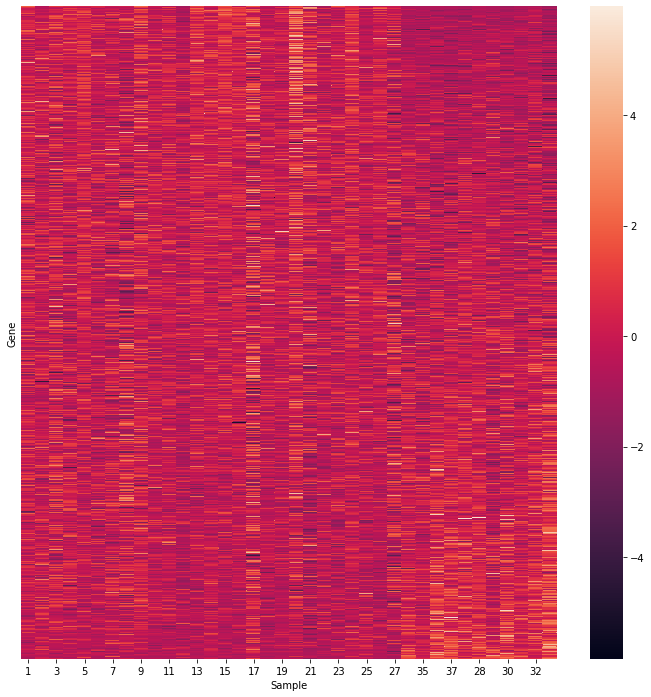

In [196]:
# heatmap for all genes sorted by similarity 
fig = plt.figure()
ax = sns.heatmap(data=df_sorted, yticklabels=False)
ax.set(xlabel='Sample', ylabel='Gene')
fig.set_size_inches(12, 12)
plt.show()


In [197]:
df_top50 = df_sorted[df_sorted.index.isin(df["similarity"].abs().sort_values(ascending = False).head(50).index.tolist())]
df_top50

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,34,35,36,37,38,28,29,30,31,32,33
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
U22376_cds2_s_at,0.078712,-0.813849,0.724661,1.139722,0.242220,0.170348,0.451997,0.815399,0.517131,-0.571281,-0.034487,-1.068545,0.815849,-0.626982,1.069647,0.627185,1.897971,-0.786897,0.223354,1.769949,2.806254,0.856277,0.069728,1.296043,-0.475152,0.150584,-0.023706,-0.810255,-0.920758,-1.103583,-1.232503,-1.010598,-0.959389,-0.726704,-1.098192,-1.132781,-0.845742,-1.165572
U05259_rna1_at,2.448602,-0.629018,-0.726482,0.984077,0.998678,-0.852785,0.922751,0.521941,-0.801315,-0.742179,-0.902065,-0.041675,0.896833,-0.899144,1.149438,0.376292,-0.876147,0.263131,0.028412,2.018589,0.068201,1.014375,-0.638144,1.218065,0.895008,2.044507,0.571586,-0.696184,-0.716991,-0.960835,-0.876147,-0.864101,-0.956455,-0.805330,-0.830518,-0.856435,-0.844024,-0.948789
X59417_at,-0.158391,0.008551,1.767984,0.170992,0.741784,0.323612,0.869445,-0.544238,1.791716,0.736874,1.283935,-1.046290,1.775758,-0.673945,1.589585,1.096944,-0.387935,-0.871575,1.259794,1.729112,0.958645,-1.106438,-0.392845,0.178766,0.194314,-0.057735,-0.651850,-1.072477,-1.191955,-0.718136,-1.176407,-1.351941,-0.900217,-0.753734,-0.726319,-0.662489,-0.895716,-0.744732
M92287_at,0.674440,-0.188648,0.735911,0.934031,0.118707,0.010302,0.342163,0.057652,1.731909,-0.198616,1.237648,-0.456131,3.121240,-0.515940,2.515666,0.079250,-0.329866,-0.763486,-0.275040,1.374712,-1.092440,0.041038,0.266570,0.389928,-0.608562,0.851377,-0.238074,-1.103239,-1.241549,-0.766394,-0.956207,-0.693708,-0.777193,-0.676679,-0.973236,-0.881444,-0.884767,-0.551245
X74262_at,0.300635,0.108285,1.169278,-0.027792,0.298589,0.233108,0.266871,-0.432955,2.573022,-0.020630,-0.128060,-0.889274,0.558465,0.994322,0.938049,0.559488,2.108518,-0.200702,0.389648,3.248293,-0.317340,-0.923037,-0.221165,0.338491,-0.602795,-0.370543,-0.591541,-0.817654,-0.759335,-0.904621,-0.970102,-1.050929,-0.493320,-0.786960,-0.782867,-0.821747,-0.784914,-1.083670
U09087_s_at,1.984999,-0.542743,1.114943,0.702811,0.409739,0.620384,0.025083,0.235728,2.232278,0.043400,-0.478634,-0.954875,1.298112,0.345630,1.582025,-0.322940,1.774354,-0.203879,-0.460317,1.160735,-1.220471,-1.018984,1.765195,0.574592,-0.551902,-0.295464,-0.020710,-0.982351,-0.854132,-0.616011,-0.817498,-0.991509,-0.460317,-0.762547,-1.156362,-0.735071,-0.835815,-1.293739
L13278_at,1.023944,-0.606565,1.074269,-0.002672,1.034009,0.047652,0.872971,0.208690,1.074269,-0.827992,-0.556240,-1.140003,0.792452,0.973620,1.265501,1.496993,1.637901,-0.596500,1.094398,2.483351,0.279144,-0.848122,-0.063062,1.003815,-0.777668,-0.858186,-0.123451,-0.858186,-0.989030,-0.697149,-1.240652,-1.079614,-0.757538,-1.089678,-1.079614,-0.314683,-0.576370,-1.361430
M31211_s_at,0.540909,0.001044,0.365290,0.121375,0.736041,-0.317672,-0.408733,-0.558335,1.766988,1.031991,1.503560,-0.327428,0.758806,-0.551830,1.506812,0.752302,-0.197340,0.264472,0.124627,3.422357,0.823850,-0.948598,-0.190836,0.313255,0.150645,0.690510,-0.942094,-0.916076,-1.351871,-1.127469,-0.961607,-1.169748,-0.438003,-0.642892,-1.088443,-0.789241,-0.311167,-1.221783
M31523_at,0.320692,-0.149950,-0.485646,0.682038,0.322923,-0.273745,-0.096418,0.986506,0.454524,-0.658512,-0.463340,-0.622823,1.044500,-0.386387,1.717006,0.453409,-0.048461,0.171246,0.213627,3.928579,1.867567,-0.845877,-0.493452,0.881671,-0.534717,0.977584,0.048567,-0.817995,-0.717621,-1.010936,-0.939559,-0.844761,-0.757771,-0.840300,-0.872643,-0.726543,-0.403116,-0.928406


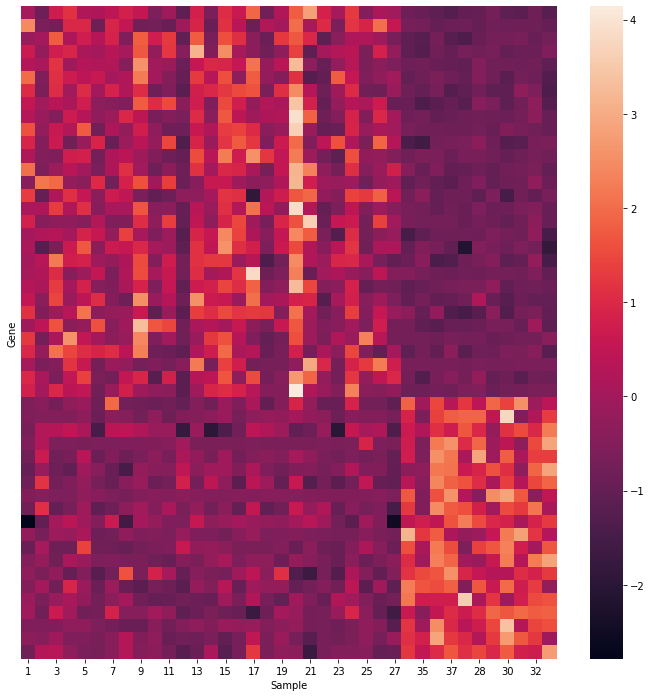

In [198]:
# heatmap for top 50 all/aml associated genes sorted by similarity 
fig = plt.figure()
ax = sns.heatmap(data=df_top50, yticklabels=False)
ax.set(xlabel='Sample', ylabel='Gene')
fig.set_size_inches(12, 12)
plt.show()

In [199]:
df[df.index.isin(df["similarity"].sort_values(ascending = False).head(25).index.tolist())]
df[df.index.isin(df["similarity"].sort_values(ascending = False).tail(25).index.tolist())]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,34,35,36,37,38,28,29,30,31,32,33,all_mean,all_std,aml_mean,aml_std,similarity
Gene Accession Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D49950_at,-0.475409,0.052874,-0.778682,0.923562,-0.133003,-0.886295,-0.084088,-0.896079,-1.121088,-0.680852,-0.837380,-1.140654,-0.201484,-0.504758,0.336581,-0.935211,-0.064522,-0.240617,-0.221050,-0.993909,-0.739550,-0.485192,-0.788465,0.434412,-1.121088,-0.064522,-1.091739,2.263835,1.676854,1.559458,1.833383,-0.524324,1.696420,0.649638,1.980128,0.718119,1.324666,-0.230833,-0.471786,0.535007,1.177031,0.911591,-5.145348
L08246_at,-0.767718,0.665116,-0.801931,-0.651510,0.358965,-0.866818,-0.521145,-0.849712,-0.626145,-0.328253,-0.655639,0.147785,-0.259236,-0.650330,-0.074602,-0.720527,-0.488702,-0.381342,-0.492241,0.073460,-0.275753,-0.621426,-0.736454,-0.576005,-0.713448,-0.600190,-0.975947,0.756548,-0.584853,2.545082,2.158117,0.140707,2.874829,-0.046287,1.811264,0.124780,1.351743,1.345844,-0.458880,0.394390,1.134343,1.145277,-4.623904
M11147_at,-0.831462,1.175391,-0.707316,-0.553564,-0.226042,-0.696382,-0.944505,-0.417139,-0.156399,-0.886302,-0.729017,0.827514,-0.702775,0.456928,-0.312002,-1.117098,0.389472,-0.097186,-0.993794,0.610175,-1.255038,-0.721110,-1.115584,-0.729690,0.490740,-0.949216,-1.051493,0.344053,-0.421512,2.382027,1.836324,1.642368,1.067227,0.109555,1.347648,0.322184,1.482391,1.873501,-0.416403,0.665495,1.089615,0.880801,-4.653865
M16038_at,-0.503224,-0.198444,-0.805651,0.094569,-0.125484,-0.577360,-0.550294,-0.645612,-0.611486,-0.763288,-0.892731,-0.463214,-0.602072,-0.239630,0.072211,-0.592658,-0.304352,-0.297291,-0.880964,-0.207858,-0.406730,-0.651496,-0.922150,-0.326710,-0.873903,-0.617370,-0.364367,1.037153,-0.067823,2.276280,1.890303,-0.010162,-0.133722,0.602929,2.237447,0.276967,2.220973,2.859953,-0.491021,0.282772,1.199118,1.122261,-5.039092
M21551_rna1_at,-0.682415,0.248581,0.301613,0.472492,0.160196,-1.471994,0.384106,0.413568,0.230904,-0.134423,-0.157993,-1.801968,-0.152101,-1.966955,-1.354147,-0.788478,0.407676,0.230904,-0.087284,-1.041850,-0.835617,-0.169778,-2.008201,0.578555,0.065918,0.213227,-1.354147,0.655156,0.195550,1.126546,0.714080,1.698108,0.955667,-0.205132,1.138331,1.533121,0.991022,2.228422,-0.381467,0.818193,1.002806,0.679548,-4.561819
M23197_at,-0.242499,-0.695527,-0.106591,-0.166051,0.136912,-0.817278,-0.743661,-0.270813,-0.542630,-0.508653,-0.585101,-0.168882,-0.551124,-0.570944,-0.752155,-0.409553,-0.171713,-0.582270,-0.542630,-0.471844,-0.587933,-0.630404,-0.675707,-0.692696,-0.406722,-0.619079,-0.743661,3.124064,1.229842,1.764981,0.173720,-0.202859,-0.086771,0.589940,2.218009,2.806945,1.210022,0.272820,-0.485897,0.238102,1.190974,1.163994,-4.952661
M27891_at,-0.433475,-0.205920,-0.444044,-0.564400,-0.517379,-0.246902,-0.549085,-0.552105,-0.426357,-0.391415,-0.579929,-0.475750,-0.519751,-0.321962,-0.482437,-0.491064,-0.417945,-0.494084,-0.537654,-0.454613,-0.525575,-0.520830,-0.407161,-0.543046,-0.548223,-0.484594,-0.491496,-0.167312,-0.179390,3.354067,2.369004,-0.140566,-0.267392,1.002815,2.640560,1.062345,2.162588,0.289307,-0.467674,0.092105,1.102366,1.323379,-4.463684
M55150_at,-0.756575,0.325468,0.330629,-0.307587,-0.622395,-0.692925,-0.414243,0.248057,-0.467571,-0.359195,-0.711848,-1.172878,-0.938922,0.108716,-1.215884,-0.665401,1.252688,-0.612073,-0.321349,-0.402201,-1.723361,-0.701527,-0.500256,-0.500256,-0.433166,-0.997411,-0.916559,1.233765,0.537060,1.054858,1.682753,1.133990,1.436756,0.951643,1.751563,0.793379,0.722848,2.751034,-0.487705,0.581755,1.277241,0.620818,-6.320147
M62762_at,-0.784481,1.125988,-0.977493,-0.699078,-0.075635,-1.071436,-0.845118,-0.367714,-0.010728,-0.483008,0.099442,-0.617945,-0.231923,-0.735802,-0.382232,-0.991157,0.531582,-1.034713,-0.806686,0.616131,-0.204594,0.190823,-0.923689,-0.442869,-0.700786,-0.546206,-1.505285,1.266050,-0.536812,2.471089,1.754556,1.571793,0.809997,-0.014998,1.536778,1.282276,2.131184,0.100296,-0.439800,0.58

In [200]:
all_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).head(25).index.tolist())]
aml_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).tail(25).index.tolist())]

top50_markers = all_markers.append(aml_markers)
top50_markers.index.tolist()

['AF009426_at',
 'J05243_at',
 'L13278_at',
 'L47738_at',
 'M91432_at',
 'M92287_at',
 'S50223_at',
 'U05259_rna1_at',
 'U20998_at',
 'U32944_at',
 'X15949_at',
 'X52142_at',
 'X59417_at',
 'X63469_at',
 'X74262_at',
 'Z69881_at',
 'D38073_at',
 'Z15115_at',
 'D26156_s_at',
 'U22376_cds2_s_at',
 'M31211_s_at',
 'U09087_s_at',
 'M31523_at',
 'M28170_at',
 'U29175_at',
 'D49950_at',
 'L08246_at',
 'M11147_at',
 'M16038_at',
 'M21551_rna1_at',
 'M23197_at',
 'M27891_at',
 'M55150_at',
 'M62762_at',
 'M63138_at',
 'M69043_at',
 'M80254_at',
 'M81933_at',
 'M84526_at',
 'U12471_cds1_at',
 'U46751_at',
 'U50136_rna1_at',
 'U82759_at',
 'X04085_rna1_at',
 'X17042_at',
 'X95735_at',
 'Y12670_at',
 'Y00787_s_at',
 'M81695_s_at',
 'X58431_rna2_s_at']

In [201]:
genes_df[genes_df["Gene Accession Number"].isin(top50_markers.index.tolist())] # several repeated genes; going to annotate each gene with "Gene description [Gene Accession #]""

,Gene Accession Number,Gene Description
148,AF009426_at,"Clone 22 mRNA, alternative splice variant alpha-1"
460,D49950_at,Liver mRNA for interferon-gamma inducing facto...
1143,J05243_at,"SPTAN1 Spectrin, alpha, non-erythrocytic 1 (al..."
1248,L08246_at,INDUCED MYELOID LEUKEMIA CELL DIFFERENTIATION ...
1305,L13278_at,CRYZ Crystallin zeta (quinone reductase)
1629,L47738_at,Inducible protein mRNA
1673,M11147_at,"FTL Ferritin, light polypeptide"
1744,M16038_at,LYN V-yes-1 Yamaguchi sarcoma viral related on...
1806,M21551_rna1_at,Neuromedin B mRNA
1833,M23197_at,CD33 CD33 antigen (differentiation antigen)


In [202]:
top50_markers = top50_markers.drop(columns = ["all_mean", "all_std", "aml_mean", "aml_std", "similarity"])
top50_markers.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '34', '35', '36', '37', '38', '28', '29', '30', '31', '32',
       '33'],
      dtype='object')

In [203]:
genes_df["combo"] = genes_df["Gene Description"] + " [" + genes_df["Gene Accession Number"] + "]" # making gene description + accession number

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [204]:
top50_markers.index = genes_df[genes_df["Gene Accession Number"].isin(top50_markers.index.tolist())]["combo"].tolist()

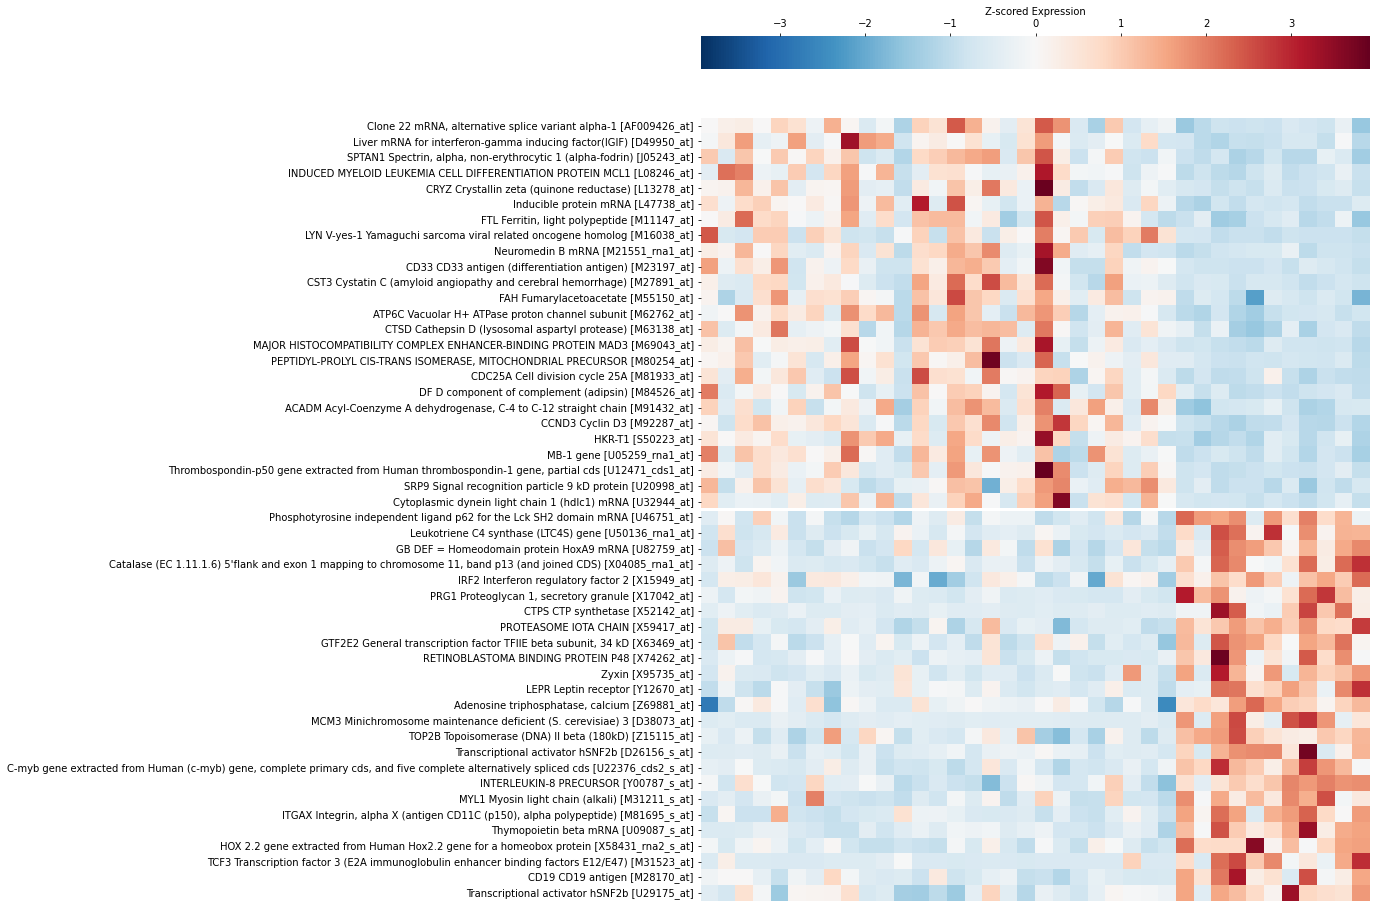

In [205]:
fig = plt.figure()
ax = sns.heatmap(data=top50_markers, yticklabels=True, xticklabels=False, cmap="RdBu_r", center = 0, vmin = -(top50_markers.to_numpy().max()), vmax = top50_markers.to_numpy().max(), cbar_kws = dict(use_gridspec=False,location="top", label='Z-scored Expression'))
ax.set_ylabel("")
ax.axhline(25, 0, 1, linewidth=3, c='w')
fig.set_size_inches(12, 18)
plt.show()

In [206]:
gene_conversion_df = genes_df[genes_df["combo"].isin(top50_markers.index)]

In [207]:
paper_accessions = ["U22376", "X59417", "U05259", "M92287", "M31211", "X74262", "D26156", "S50223", "M31523", "L47738", "U32944", "Z15115", "X15949",
                    "X63469", "M91432", "U29175", "Z69881", "U20998", "D38073", "U26266", "M31303", "Y08612", "U35451", "M29696", "M13792",###
                    "M55150", "X95735", "U50136", "M16038", "U82759", "M23197", "M84526", "Y12670", "M27891", "X17042", "Y00787", "M96326",
                    "U46751", "M80254", "L08246", "M62762", "M28130", "M63138", "M57710", "M69043", "M81695", "X85116", "M19045", "M83652", "X04085"]
len(paper_accessions)

50

In [208]:
true_count = 0
for i in paper_accessions:
  res = any(s.startswith(i) for s in gene_conversion_df["Gene Accession Number"])
  if res == True:
    true_count = true_count + 1
  else:
    true_count = true_count
print(true_count)

38


In [209]:
# ALL count
true_count = 0
for i in paper_accessions[0:25]:
  res = any(s.startswith(i) for s in gene_conversion_df["Gene Accession Number"])
  if res == True:
    true_count = true_count + 1
  else:
    true_count = true_count
print(true_count)

# AML count
true_count = 0
for i in paper_accessions[26:50]:
  res = any(s.startswith(i) for s in gene_conversion_df["Gene Accession Number"])
  if res == True:
    true_count = true_count + 1
  else:
    true_count = true_count
print(true_count)

## 19/25 ALL markers from paper recapitulated; 18/25 AML markers from paper recapitulated; 

19
18


## Classifier Development
We'll now train a model using the top 50 genes correlated with ALL or AML diagnosis to determine if this gene expression can serve as a viable predictor of class.

We utilize logistic regression to accomplish this task.

In [210]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import LeaveOneOut

In [211]:
# scikit learn needs each row to represent a sample
# for this reason we need to transpose the dataframe
top50_markers = top50_markers.transpose()
top50_markers.head()

,"Clone 22 mRNA, alternative splice variant alpha-1 [AF009426_at]",Liver mRNA for interferon-gamma inducing factor(IGIF) [D49950_at],"SPTAN1 Spectrin, alpha, non-erythrocytic 1 (alpha-fodrin) [J05243_at]",INDUCED MYELOID LEUKEMIA CELL DIFFERENTIATION PROTEIN MCL1 [L08246_at],CRYZ Crystallin zeta (quinone reductase) [L13278_at],Inducible protein mRNA [L47738_at],"FTL Ferritin, light polypeptide [M11147_at]",LYN V-yes-1 Yamaguchi sarcoma viral related oncogene homolog [M16038_at],Neuromedin B mRNA [M21551_rna1_at],CD33 CD33 antigen (differentiation antigen) [M23197_at],CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage) [M27891_at],FAH Fumarylacetoacetate [M55150_at],ATP6C Vacuolar H+ ATPase proton channel subunit [M62762_at],CTSD Cathepsin D (lysosomal aspartyl protease) [M63138_at],MAJOR HISTOCOMPATIBILITY COMPLEX ENHANCER-BINDING PROTEIN MAD3 [M69043_at],"PEPTIDYL-PROLYL CIS-TRANS ISOMERASE, MITOCHONDRIAL PRECURSOR [M80254_at]",CDC25A Cell division cycle 25A [M81933_at],DF D component of complement (adipsin) [M84526_at],"ACADM Acyl-Coenzyme A dehydrogenase, C-4 to C-12 straight chain [M91432_at]",CCND3 Cyclin D3 [M92287_at],HKR-T1 [S50223_at],MB-1 gene [U05259_rna1_at],"Thrombospondin-p50 gene extracted from Human thrombospondin-1 gene, partial cds [U12471_cds1_at]",SRP9 Signal recognition particle 9 kD protein [U20998_at],Cytoplasmic dynein light chain 1 (hdlc1) mRNA [U32944_at],Phosphotyrosine independent ligand p62 for the Lck SH2 domain mRNA [U46751_at],Leukotriene C4 synthase (LTC4S) gene [U50136_rna1_at],GB DEF = Homeodomain protein HoxA9 mRNA [U82759_at],"Catalase (EC 1.11.1.6) 5'flank and exon 1 mapping to chromosome 11, band p13 (and joined CDS) [X04085_rna1_at]",IRF2 Interferon regulatory factor 2 [X15949_at],"PRG1 Proteoglycan 1, secretory granule [X17042_at]",CTPS CTP synthetase [X52142_at],PROTEASOME IOTA CHAIN [X59417_at],"GTF2E2 General transcription factor TFIIE beta subunit, 34 kD [X63469_at]",RETINOBLASTOMA BINDING PROTEIN P48 [X74262_at],Zyxin [X95735_at],LEPR Leptin receptor [Y12670_at],"Adenosine triphosphatase, calcium [Z69881_at]",MCM3 Minichromosome maintenance deficient (S. cerevisiae) 3 [D38073_at],TOP2B Topoisomerase (DNA) II beta (180kD) [Z15115_at],Transcriptional activator hSNF2b [D26156_s_at],"C-myb gene extracted from Human (c-myb) gene, complete primary cds, and five complete alternatively spliced cds [U22376_cds2_s_at]",INTERLEUKIN-8 PRECURSOR [Y00787_s_at],MYL1 Myosin light chain (alkali) [M31211_s_at],"ITGAX Integrin, alpha X (antigen CD11C (p150), alpha polypeptide) [M81695_s_at]",Thymopoietin beta mRNA [U09087_s_at],HOX 2.2 gene extracted from Human Hox2.2 gene for a homeobox protein [X58431_rna2_s_at],TCF3 Transcription factor 3 (E2A immunoglobulin enhancer binding factors E12/E47) [M31523_at],CD19 CD19 antigen [M28170_at],Transcriptional activator hSNF2b [U29175_at]
1,0.004005,-0.070614,1.023944,-0.413032,0.108351,0.674440,0.006684,2.448602,0.299016,1.619592,0.233020,0.146864,-0.158391,1.160123,0.300635,0.066376,0.526544,2.033313,0.915078,0.078712,0.540909,1.984999,0.320692,1.309599,0.825059,-0.475409,-0.767718,-0.831462,-0.503224,-0.682415,-0.242499,-0.433475,-0.756575,-0.784481,-0.592705,-0.721459,-0.960210,-2.784934,-0.530579,-0.321128,-0.546571,-0.339110,-0.063122,-0.588642,-0.910312,-0.558979,-0.120785,-0.563873,-0.181241,-0.490074
2,0.233163,0.430292,-0.606565,2.157404,0.181296,-0.188648,0.328029,-0.629018,0.146442,-0.242064,-0.501795,-1.227280,0.008551,-0.527763,0.108285,0.203658,-0.403813,-0.578903,-0.463220,-0.813849,0.001044,-0.542743,-0.149950,-0.950897,-0.445381,0.052874,0.665116,1.175391,-0.198444,0.248581,-0.695527,-0.205920,0.325468,1.125988,-0.222380,0.172893,-0.167508,-1.003452,-0.434237,-0.612307,-0.512578,-0.409631,-0.796670,-0.418307,0.069122,-0.552956,-0.623822,0.267350,0.019779,-0.698869
3,0.285244,1.647006,1.074269,1.969216,1.318934,0.735911,2.214900,-0.726482,1.317525,0.620151,-0.557012,-0.599278,1.767984,-0.096232,1.169278,1.053267,1.440543,-0.099222,0.

In [212]:
top50_all = top50_markers[top50_markers.index.isin(all_list)]
top50_aml = top50_markers[top50_markers.index.isin(aml_list)]

top50_all["label_code"] = 0
top50_aml["label_code"] = 1

print(top50_all.columns)
print(top50_aml.columns)

Index(['Clone 22 mRNA, alternative splice variant alpha-1 [AF009426_at]',
       'Liver mRNA for interferon-gamma inducing factor(IGIF) [D49950_at]',
       'SPTAN1 Spectrin, alpha, non-erythrocytic 1 (alpha-fodrin) [J05243_at]',
       'INDUCED MYELOID LEUKEMIA CELL DIFFERENTIATION PROTEIN MCL1 [L08246_at]',
       'CRYZ Crystallin zeta (quinone reductase) [L13278_at]',
       'Inducible protein mRNA [L47738_at]',
       'FTL Ferritin, light polypeptide [M11147_at]',
       'LYN V-yes-1 Yamaguchi sarcoma viral related oncogene homolog [M16038_at]',
       'Neuromedin B mRNA [M21551_rna1_at]',
       'CD33 CD33 antigen (differentiation antigen) [M23197_at]',
       'CST3 Cystatin C (amyloid angiopathy and cerebral hemorrhage) [M27891_at]',
       'FAH Fumarylacetoacetate [M55150_at]',
       'ATP6C Vacuolar H+ ATPase proton channel subunit [M62762_at]',
       'CTSD Cathepsin D (lysosomal aspartyl protease) [M63138_at]',
       'MAJOR HISTOCOMPATIBILITY COMPLEX ENHANCER-BINDING PROTEIN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [213]:
top50 = top50_all.append(top50_aml)
print(top50.shape)

(38, 51)


In [214]:
X_train, X_test, y_train, y_test = train_test_split(
    top50.drop(columns=['label_code']), 
    top50['label_code'], 
    test_size=0.33, 
    random_state=42)

In [215]:
# create a new logistic regression model
# There are many different solvers: 
# .  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#   They all have their strenghts/weaknesses
lr = LogisticRegression(random_state=0, solver='liblinear')
# train the model using the training data
clf = lr.fit(X_train, y_train)
# now that the model has been trained, predict the classes in the test set
pred = clf.predict(X_test)
# predict outputs labels, decision_function outputs the confidence scores
y_scores = clf.decision_function(X_test)
# print the accuracy sum(predicted == actual) / len(labels)
print('Predicted Class:\t', pred)
print('Actual Class: \t\t', y_test.to_numpy())

Predicted Class:	 [1 1 0 0 1 0 0 1 0 0 0 0 0]
Actual Class: 		 [1 1 0 0 1 0 0 1 0 0 0 0 0]


In [216]:
# y_scores contains the confidence scores
y_scores

array([ 6.16956829,  6.62204045, -2.6328753 , -3.14917564, 10.14300836,
       -4.93445859, -1.72694459,  8.38203294, -2.04785274, -4.32721343,
       -2.46889213, -5.03609058, -0.42127347])

In [217]:
# scoring the model will return the accuracy
# this uses the test features and test labels
clf.score(X_test, y_test) # score of 1

1.0

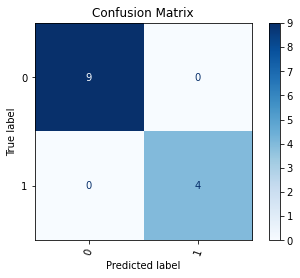

In [218]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=["0", "1"],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Confusion Matrix')
disp.ax_.grid(False)
disp.ax_.tick_params(axis='x', rotation=70)

_ = disp.confusion_matrix # confusion matrix correctly classifies all samples in training test dataset

In [219]:
# Leave one out cross validation using scikit

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(top50)

max_probs = []
clf_scores_list = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(top50):
    # split the data into train and test sets using the indicies
    top50, 
    top50,
    X_train = top50.iloc[train_index].drop(columns=['label_code'])
    X_test = top50.iloc[test_index].drop(columns=['label_code'])
    y_train = top50.iloc[train_index]['label_code']
    y_test = top50.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ') # model was 100% accurate for all conditions
    clf_scores_list.append(clf.score(X_test, y_test))
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [220]:
sum(clf_scores_list)/len(clf_scores_list) # 100% accuracy across LOO cross-validation

1.0

In [221]:
probs_df = pd.DataFrame({'Number of genes':["50"] * 38,
                          'Prediction Strength':max_probs})


In [222]:
probs_df["Prediction Strength"]

0     0.995074
1     0.718751
2     0.981535
3     0.944194
4     0.966345
5     0.991457
6     0.853780
7     0.941694
8     0.997009
9     0.923392
10    0.989183
11    0.831587
12    0.996505
13    0.975801
14    0.997043
15    0.994350
16    0.631081
17    0.957661
18    0.967911
19    0.999538
20    0.992230
21    0.969970
22    0.983471
23    0.963233
24    0.884031
25    0.988037
26    0.995284
27    0.999893
28    0.801652
29    0.999998
30    0.999991
31    0.997117
32    0.995701
33    0.998917
34    0.999998
35    0.998555
36    0.999627
37    0.999899
Name: Prediction Strength, dtype: float64

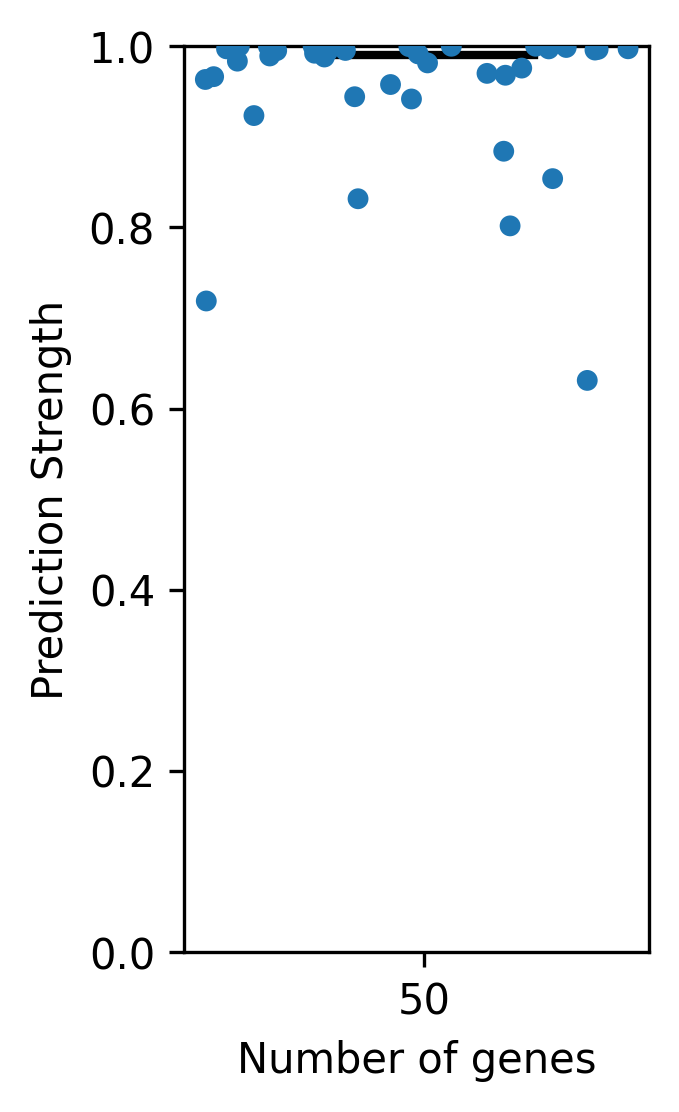

In [223]:
fig = plt.figure(figsize=(2, 4), dpi=300)
ax = sns.stripplot(x = probs_df["Number of genes"], y = probs_df["Prediction Strength"], orient='v')
plt.ylim(0, 1.00)

# 
median_width = 0.1

for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()): # add median line
  sample_name = text.get_text()  # "X" or "Y"

  median_val = probs_df[probs_df['Number of genes']==sample_name]["Prediction Strength"].median()

  ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=2, color='k')

fig.show()


In [224]:
# repeat with different numbers of top genes: (top 2, 10, 100, 250, 500, 1000)

# first let's generate the dataframes for the top2, 10, 100, 250, 500, and 1000 genes; 

# top 2
all_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).head(1).index.tolist())]
aml_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).tail(1).index.tolist())]

top2_markers = all_markers.append(aml_markers)
top2_markers.index.tolist()

# top 10
all_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).head(5).index.tolist())]
aml_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).tail(5).index.tolist())]

top10_markers = all_markers.append(aml_markers)
top10_markers.index.tolist()

# top 100
all_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).head(50).index.tolist())]
aml_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).tail(50).index.tolist())]

top100_markers = all_markers.append(aml_markers)
top100_markers.index.tolist()

# top 250
all_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).head(125).index.tolist())]
aml_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).tail(125).index.tolist())]

top250_markers = all_markers.append(aml_markers)
top250_markers.index.tolist()

# top 500
all_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).head(250).index.tolist())]
aml_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).tail(250).index.tolist())]

top500_markers = all_markers.append(aml_markers)
top500_markers.index.tolist()


# top 1000
all_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).head(500).index.tolist())]
aml_markers = df[df.index.isin(df["similarity"].sort_values(ascending = False).tail(500).index.tolist())]

top1000_markers = all_markers.append(aml_markers)
top1000_markers.index.tolist()


['AFFX-CreX-5_st',
 'AFFX-PheX-M_at',
 'AB000449_at',
 'AB003698_at',
 'AF000231_at',
 'AF005043_at',
 'AF009426_at',
 'AF015913_at',
 'AF015950_at',
 'D00763_at',
 'D13627_at',
 'D13636_at',
 'D14658_at',
 'D14659_at',
 'D15057_at',
 'D21063_at',
 'D21262_at',
 'D21851_at',
 'D21852_at',
 'D23673_at',
 'D25328_at',
 'D26018_at',
 'D30037_at',
 'D31886_at',
 'D31891_at',
 'D32050_at',
 'D38048_at',
 'D38128_at',
 'D38522_at',
 'D38524_at',
 'D38548_at',
 'D38552_at',
 'D38751_at',
 'D42039_at',
 'D42043_at',
 'D43948_at',
 'D43950_at',
 'D45248_at',
 'D50063_at',
 'D50912_at',
 'D50918_at',
 'D50923_at',
 'D50930_at',
 'D55654_at',
 'D63391_at',
 'D63477_at',
 'D63482_at',
 'D63486_at',
 'D63874_at',
 'D63880_at',
 'D78275_at',
 'D79988_at',
 'D79998_at',
 'D80001_at',
 'D80006_at',
 'D83032_at',
 'D83776_at',
 'D83782_at',
 'D83783_at',
 'D83785_at',
 'D84276_at',
 'D84294_at',
 'D85758_at',
 'D86479_at',
 'D86967_at',
 'D86978_at',
 'D86983_at',
 'D87076_at',
 'D87078_at',
 'D87446_a

In [225]:
# top 2
top2_markers = top2_markers.transpose()
top2_markers.head()

top2_all = top2_markers[top2_markers.index.isin(all_list)]
top2_aml = top2_markers[top2_markers.index.isin(aml_list)]

top2_all["label_code"] = 0
top2_aml["label_code"] = 1

top2 = top2_all.append(top2_aml)
print(top2.shape)

# top 10
top10_markers = top10_markers.transpose()
top10_markers.head()

top10_all = top10_markers[top10_markers.index.isin(all_list)]
top10_aml = top10_markers[top10_markers.index.isin(aml_list)]

top10_all["label_code"] = 0
top10_aml["label_code"] = 1

top10 = top10_all.append(top10_aml)
print(top10.shape)

# top 100
top100_markers = top100_markers.transpose()
top100_markers.head()

top100_all = top100_markers[top100_markers.index.isin(all_list)]
top100_aml = top100_markers[top100_markers.index.isin(aml_list)]

top100_all["label_code"] = 0
top100_aml["label_code"] = 1

top100 = top100_all.append(top100_aml)
print(top100.shape)

# top 250
top250_markers = top250_markers.transpose()
top250_markers.head()

top250_all = top250_markers[top250_markers.index.isin(all_list)]
top250_aml = top250_markers[top250_markers.index.isin(aml_list)]

top250_all["label_code"] = 0
top250_aml["label_code"] = 1

top250 = top250_all.append(top250_aml)
print(top250.shape)

# top 500
top500_markers = top500_markers.transpose()
top500_markers.head()

top500_all = top500_markers[top500_markers.index.isin(all_list)]
top500_aml = top500_markers[top500_markers.index.isin(aml_list)]

top500_all["label_code"] = 0
top500_aml["label_code"] = 1

top500 = top500_all.append(top500_aml)
print(top500.shape)

# top 1000
top1000_markers = top1000_markers.transpose()
top1000_markers.head()

top1000_all = top1000_markers[top1000_markers.index.isin(all_list)]
top1000_aml = top1000_markers[top1000_markers.index.isin(aml_list)]

top1000_all["label_code"] = 0
top1000_aml["label_code"] = 1

top1000 = top1000_all.append(top1000_aml)
print(top1000.shape)



(38, 3)
(38, 11)
(38, 101)
(38, 251)
(38, 501)
(38, 1001)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [226]:
#### TOP 2 MARKERS

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(top2)

max_probs_top2 = []
clf_scores_list_top2 = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(top2):
    # split the data into train and test sets using the indicies
    top2, 
    top2,
    X_train = top2.iloc[train_index].drop(columns=['label_code'])
    X_test = top2.iloc[test_index].drop(columns=['label_code'])
    y_train = top2.iloc[train_index]['label_code']
    y_test = top2.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ') #
    clf_scores_list_top2.append(clf.score(X_test, y_test))
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs_top2.append(max(clf.predict_proba(X_test)[0]))

1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [227]:
#### TOP 10 MARKERS

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(top10)

max_probs_top10 = []
clf_scores_list_top10 = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(top10):
    # split the data into train and test sets using the indicies
    top10, 
    top10,
    X_train = top10.iloc[train_index].drop(columns=['label_code'])
    X_test = top10.iloc[test_index].drop(columns=['label_code'])
    y_train = top10.iloc[train_index]['label_code']
    y_test = top10.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ') # 
    clf_scores_list_top10.append(clf.score(X_test, y_test))
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs_top10.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [228]:
#### TOP 100 MARKER

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(top100)

max_probs_top100 = []
clf_scores_list_top100 = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(top100):
    # split the data into train and test sets using the indicies
    top100, 
    top100,
    X_train = top100.iloc[train_index].drop(columns=['label_code'])
    X_test = top100.iloc[test_index].drop(columns=['label_code'])
    y_train = top100.iloc[train_index]['label_code']
    y_test = top100.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ') # 
    clf_scores_list_top100.append(clf.score(X_test, y_test))
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs_top100.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [229]:
#### TOP 250 MARKERS

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(top250)

max_probs_top250 = []
clf_scores_list_top250 = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(top250):
    # split the data into train and test sets using the indicies
    top250, 
    top250,
    X_train = top250.iloc[train_index].drop(columns=['label_code'])
    X_test = top250.iloc[test_index].drop(columns=['label_code'])
    y_train = top250.iloc[train_index]['label_code']
    y_test = top250.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ') # 
    clf_scores_list_top250.append(clf.score(X_test, y_test))
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs_top250.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [230]:
#### TOP 500 MARKERS

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(top500)

max_probs_top500 = []
clf_scores_list_top500 = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(top500):
    # split the data into train and test sets using the indicies
    top500, 
    top500,
    X_train = top500.iloc[train_index].drop(columns=['label_code'])
    X_test = top500.iloc[test_index].drop(columns=['label_code'])
    y_train = top500.iloc[train_index]['label_code']
    y_test = top500.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ') # model was 100% accurate
    clf_scores_list_top500.append(clf.score(X_test, y_test))
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs_top500.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [231]:
#### TOP 1000 MARKERS

# Create a new LeaveOneOut object and assign it to loo
loo = LeaveOneOut()
# Calculate the number of splits, this uses the number of rows in the features set
loo.get_n_splits(top1000)

max_probs_top1000 = []
clf_scores_list_top1000 = []

# loo.split(features) will return column indexes for train and test sets
# . the train will have len(samples) -1 elements
# . the test set will contain a single index
for train_index, test_index in loo.split(top1000):
    # split the data into train and test sets using the indicies
    top1000, 
    top1000,
    X_train = top1000.iloc[train_index].drop(columns=['label_code'])
    X_test = top1000.iloc[test_index].drop(columns=['label_code'])
    y_train = top1000.iloc[train_index]['label_code']
    y_test = top1000.iloc[test_index]['label_code']
    
    # Create a new model each time so that the weights are reset each iteration 
    lr = LogisticRegression(solver='liblinear')
    # train the model using the training set
    clf = lr.fit(X_train, y_train)
    # print the accuracy of the model using the test set
    print(clf.score(X_test, y_test), end=', ') # 
    clf_scores_list_top1000.append(clf.score(X_test, y_test))
    # this will output the probilites per test case
    #   as we only have one test we can use zero to index it
    max_probs_top1000.append(max(clf.predict_proba(X_test)[0]))

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [232]:
print(sum(clf_scores_list_top2)/len(clf_scores_list_top2)) # 97% accurate (missed 1/38) 
print(sum(clf_scores_list_top10)/len(clf_scores_list_top10)) # 100% accurate (missed 0/38) 
print(sum(clf_scores_list)/len(clf_scores_list)) # 100% accurate (missed 0/38) 
print(sum(clf_scores_list_top100)/len(clf_scores_list_top100)) # 100% accurate (missed 0/38) 
print(sum(clf_scores_list_top250)/len(clf_scores_list_top250)) # 97% accurate (missed 1/38) 
print(sum(clf_scores_list_top500)/len(clf_scores_list_top500)) # 97% accurate (missed 1/38) 
print(sum(clf_scores_list_top1000)/len(clf_scores_list_top1000)) # 97% accurate (missed 1/38) 

percent_accuracy = [sum(clf_scores_list_top2)/len(clf_scores_list_top2), sum(clf_scores_list_top10)/len(clf_scores_list_top10),
 sum(clf_scores_list)/len(clf_scores_list), sum(clf_scores_list_top100)/len(clf_scores_list_top100), 
 sum(clf_scores_list_top250)/len(clf_scores_list_top250), sum(clf_scores_list_top500)/len(clf_scores_list_top500),
 sum(clf_scores_list_top1000)/len(clf_scores_list_top1000)]


0.9736842105263158
1.0
1.0
1.0
0.9736842105263158
0.9736842105263158
0.9736842105263158


In [233]:
probs_df = pd.DataFrame({'Number of genes':["2"] * 38 + ["10"] * 38 + ["50"] * 38 + ["100"] * 38 + ["250"] * 38 + ["500"] * 38 + ["1000"] * 38,
                          'Prediction Strength': max_probs_top2 + max_probs_top10 + max_probs + max_probs_top100 + max_probs_top250 + max_probs_top500 + max_probs_top1000})

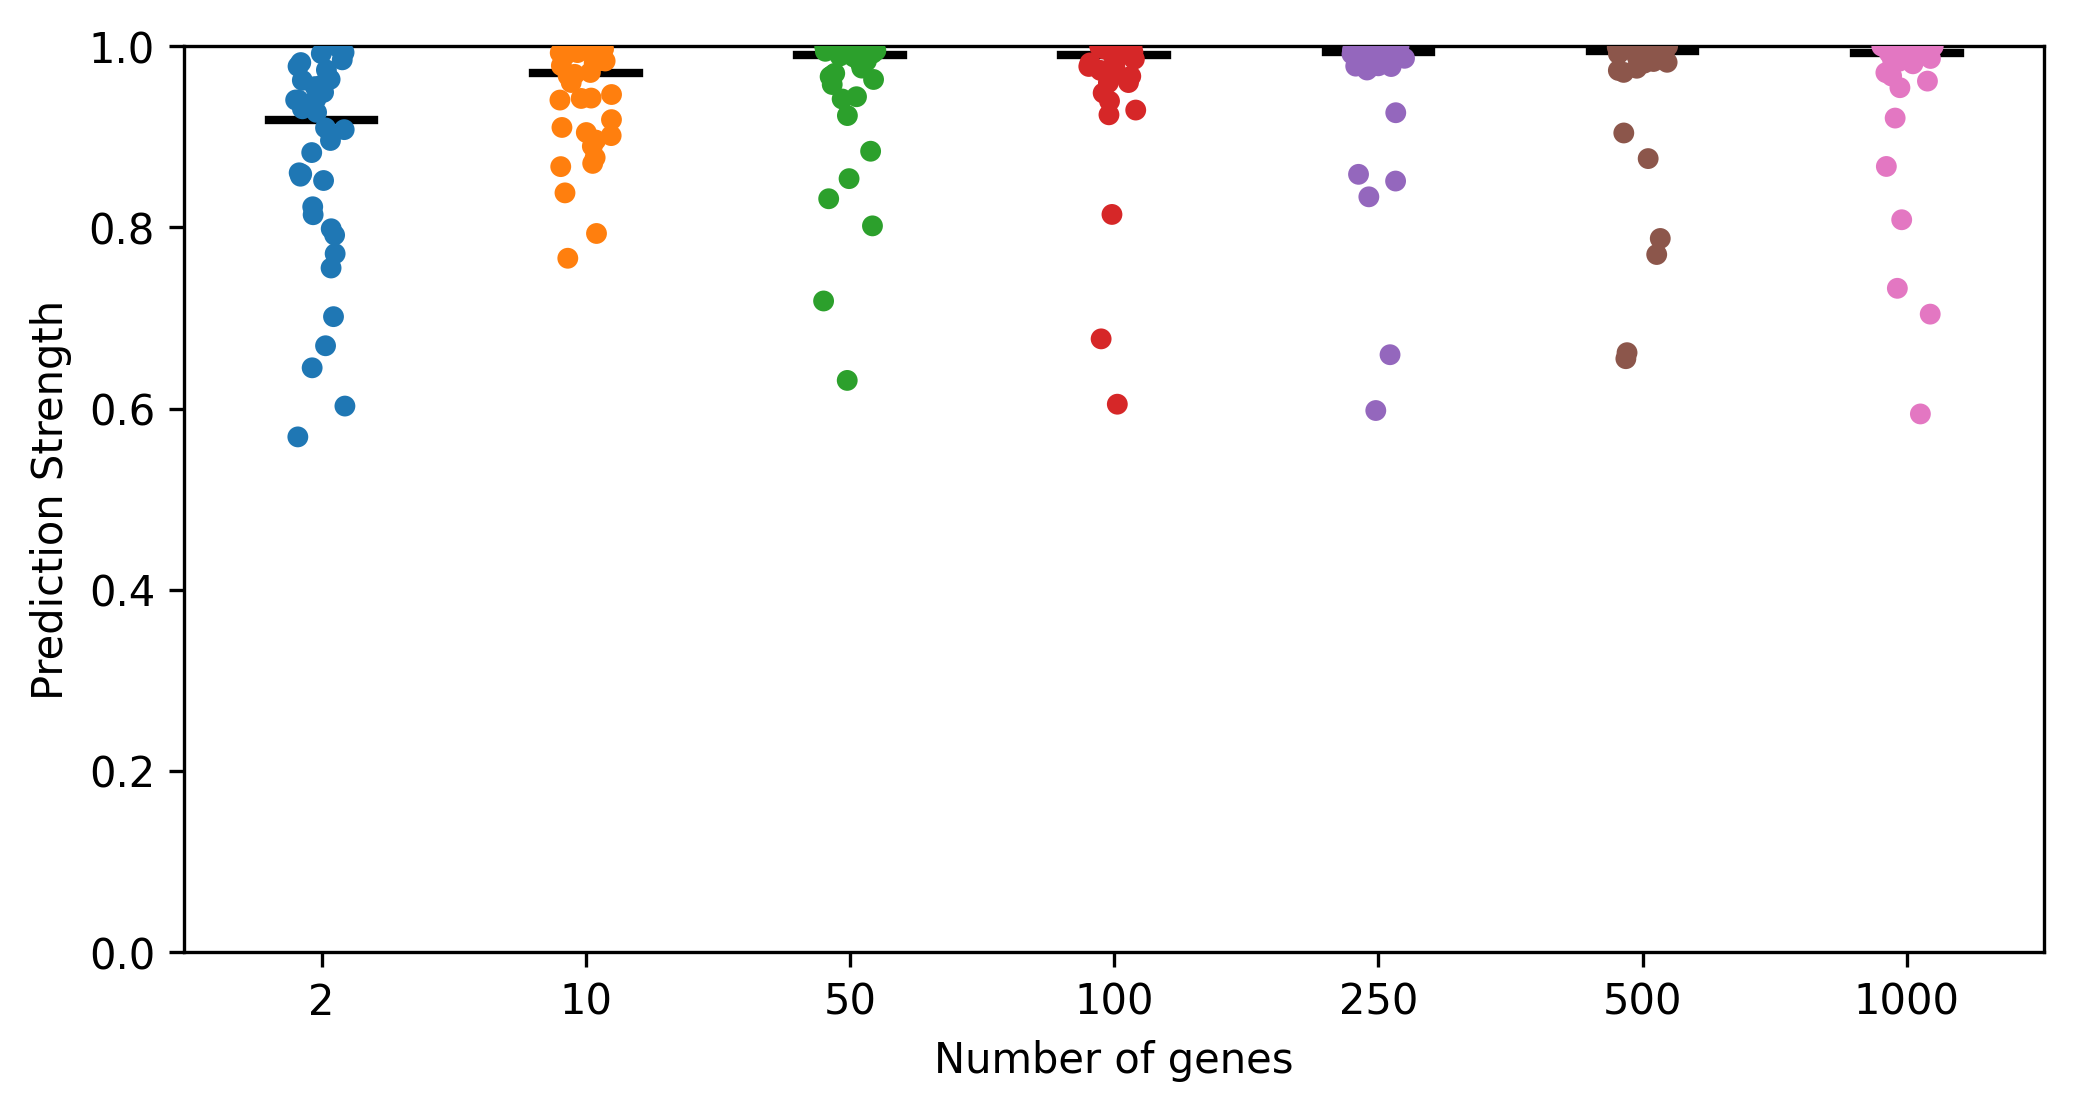

In [234]:
fig = plt.figure(figsize=(8, 4), dpi=300)
ax = sns.stripplot(x = probs_df["Number of genes"], y = probs_df["Prediction Strength"], orient='v')
plt.ylim(0, 1.00)

# 
median_width = 0.4

for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()): # add median line
  sample_name = text.get_text()  # "X" or "Y"

  median_val = probs_df[probs_df['Number of genes']==sample_name]["Prediction Strength"].median()

  ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=2, color='k')

fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


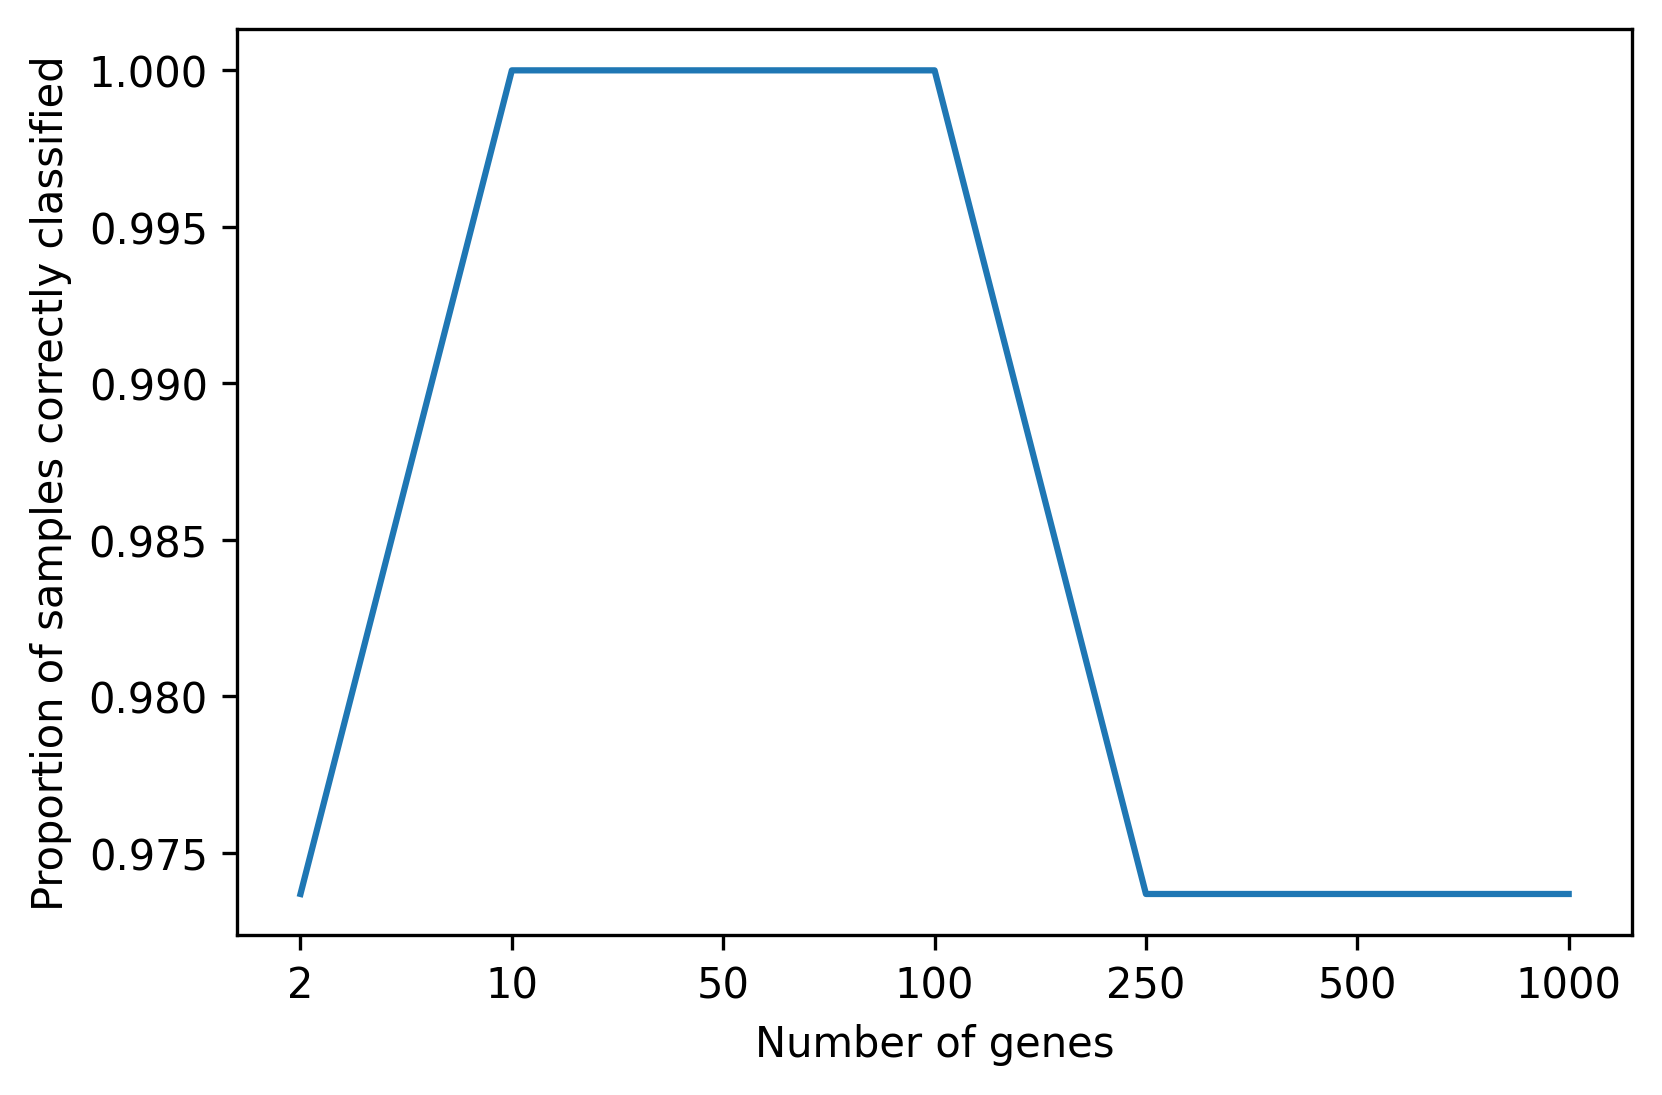

In [235]:
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = sns.lineplot(["2", "10", "50", "100", "250", "500", "1000"], percent_accuracy)
ax.set_xlabel("Number of genes")
ax.set_ylabel("Proportion of samples correctly classified")
plt.show()

## Clustering
We will utilize k-means clustering to predict classes in our dataset and determine if we can independently derive ALL and AML classes. 

In [236]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [237]:
df = df.transpose()
df.head()

df_all = df[df.index.isin(all_list)]
df_aml = df[df.index.isin(aml_list)]

df_all["label_code"] = 0
df_aml["label_code"] = 1

df = df_all.append(df_aml)
print(df.shape)


(38, 7130)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [238]:
# extract the expression levels as features from the dataframe
features = df.drop(columns=['label_code']).values
labels = df['label_code'].values
print('features:', features.shape)
print('labels:', labels.shape)

features: (38, 7129)
labels: (38,)


In [239]:
clustering = AgglomerativeClustering(n_clusters=2).fit(features)
print('Clustering Labels:\t', clustering.labels_)
print('Actual Labels:\t\t', labels)

Clustering Labels:	 [0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0
 0]
Actual Labels:		 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1]


To visualize our clusters, we'll run PCA to reduce our data to 2 dimensions

In [240]:
from sklearn.decomposition import PCA

In [241]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(features)
pc_df = pd.DataFrame(data = pcs, columns = ['PC_1', 'PC_2'])

In [242]:
pc_df.index = df.index

In [243]:
pc_df["Diagnosis"] = ["ALL"]*27 + ["AML"]*11
pc_df["Cluster"] = clustering.labels_.tolist()

In [244]:
pc_df

,PC_1,PC_2,Diagnosis,Cluster
1,18.299174,5.749807,ALL,0
2,-7.244136,9.876150,ALL,1
3,52.152090,11.239723,ALL,0
4,13.507231,-6.164106,ALL,0
5,-36.302801,32.365249,ALL,1
6,-9.513156,-20.714210,ALL,1
7,21.519971,-16.042890,ALL,0
8,55.258645,-21.132806,ALL,0
9,21.332350,30.445795,ALL,0
10,-22.571983,-8.582541,ALL,1


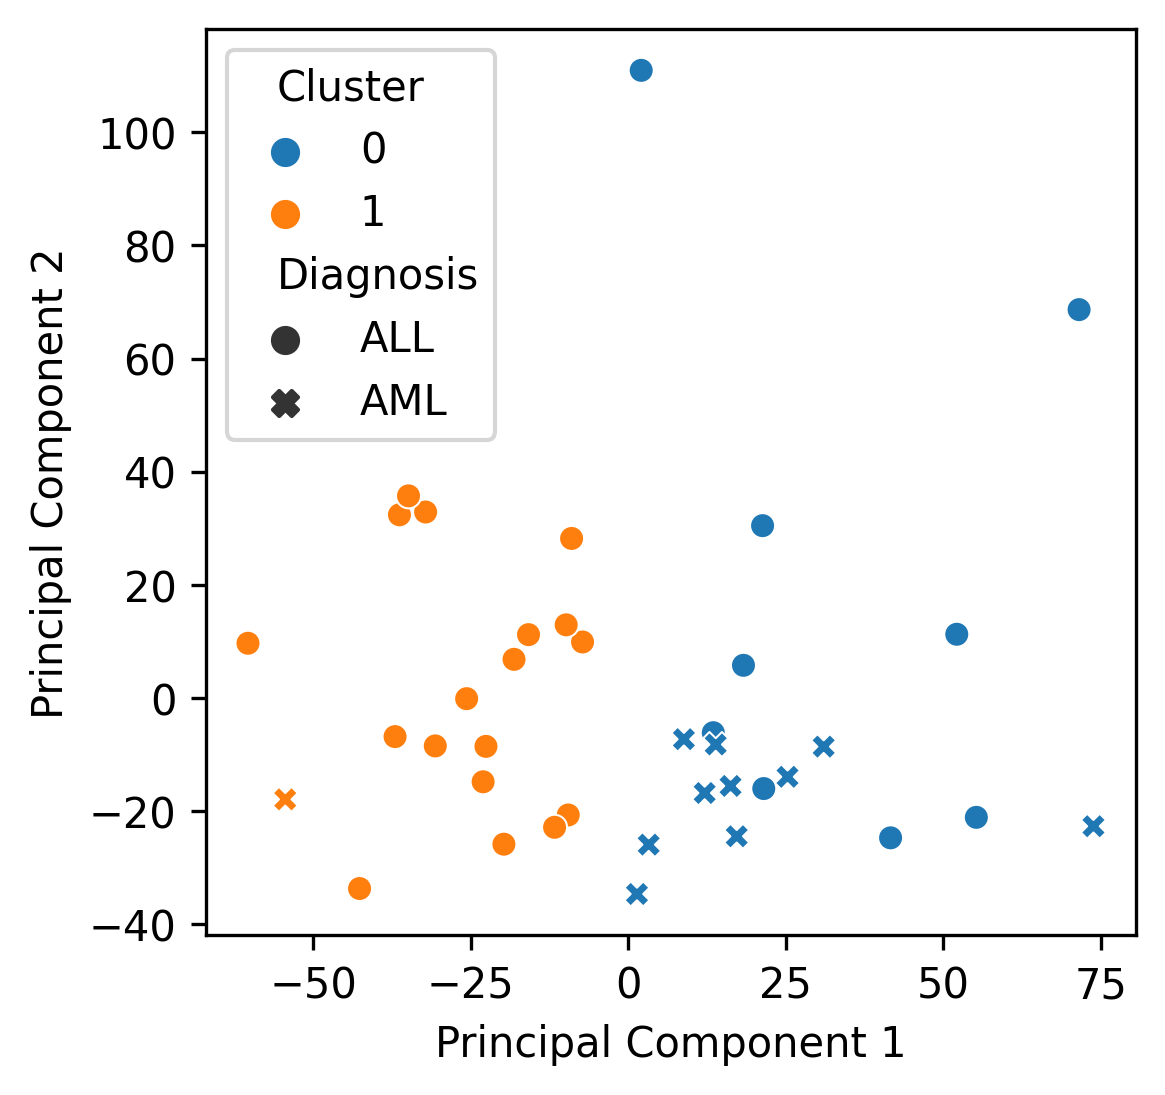

In [245]:
# 
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = sns.scatterplot(data=pc_df, x="PC_1", y="PC_2", hue="Cluster", style="Diagnosis")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.show() # we find that AML samples tend to be in cluster 1, but some all samples are in both clusters;

In [246]:
clustering = AgglomerativeClustering(n_clusters=6).fit(features)
print('Clustering Labels:\t', clustering.labels_)
print('Actual Labels:\t\t', labels)

Clustering Labels:	 [1 0 2 1 0 0 1 1 2 0 0 0 0 0 0 0 4 0 0 5 0 0 0 0 0 0 1 1 1 3 3 3 1 0 3 1 1
 3]
Actual Labels:		 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1]


In [247]:
pc_df["Cluster"] = clustering.labels_.tolist()

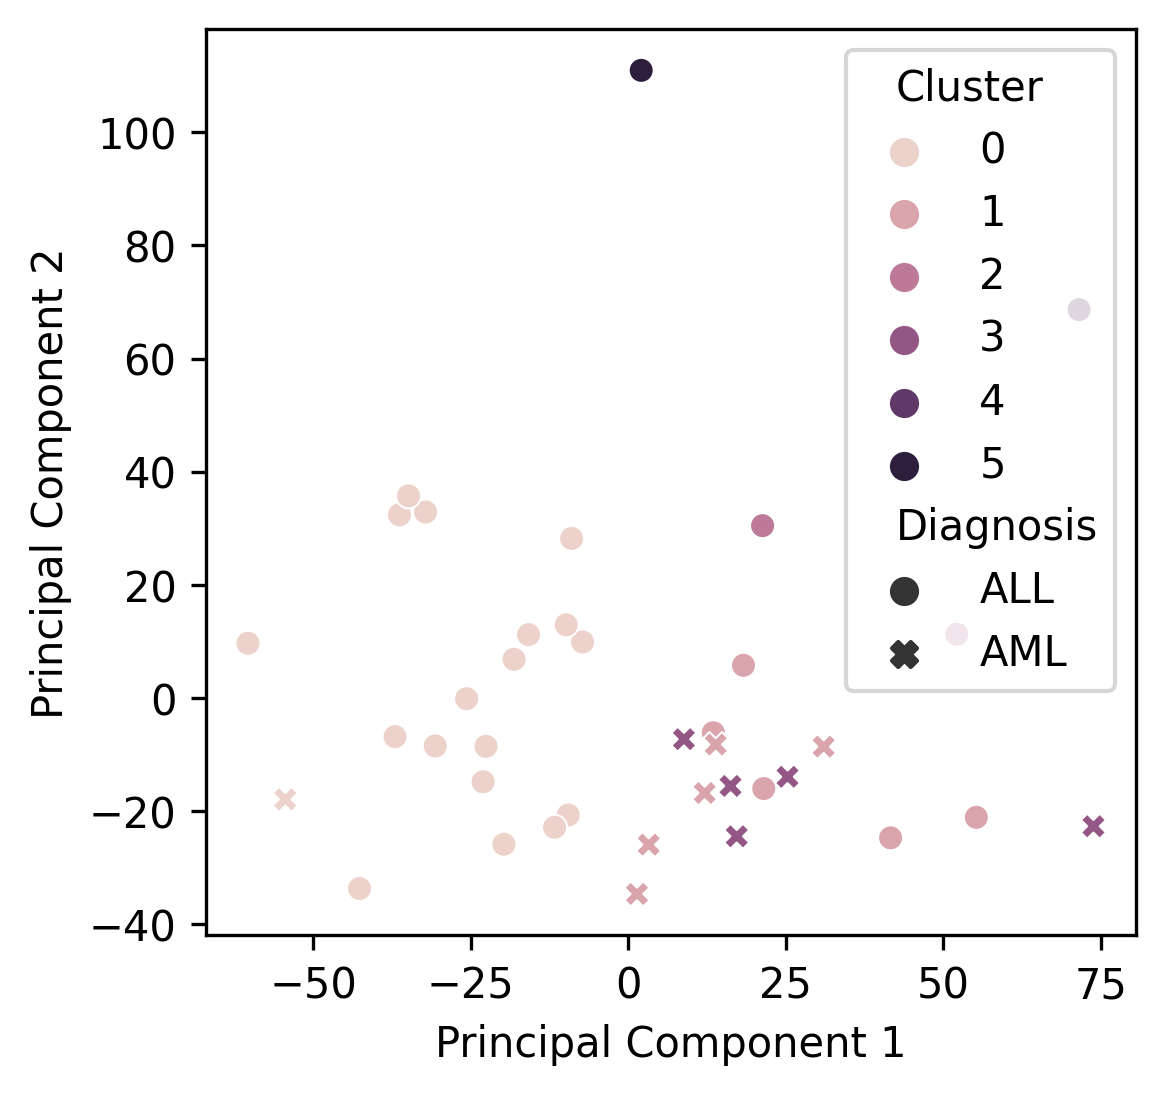

In [248]:
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = sns.scatterplot(data=pc_df, x="PC_1", y="PC_2", hue="Cluster", style="Diagnosis")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.show() # increasing the number of clusters to 3 doesn't help; just removes two outlier ALL cluster

We find that agglomerative hierarchical clustering on the whole dataset doesn't well separate ALL vs ALL samples.

This may not be suprising given the majority of genes in the data set are not variable between ALL and AML samples.
